# Scraping Sold Houses

### Import Lib

In [18]:
import numpy as np
import requests
import os
import time
import re
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import box

### Functions

In [21]:
def setup_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    return driver

def download_image(image_url, location, base_url='https://www.estately.com', save_dir='../data/estately_images/queens'):
    if not image_url.startswith('http'):
        image_url = base_url + image_url
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    filename = "".join([c for c in location if c.isalpha() or c.isdigit() or c == ' ']).rstrip()
    filename = filename.replace(' ', '_') + '.jpg'
    file_path = os.path.join(save_dir, filename)
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            filename = None
    except requests.exceptions.RequestException:
        filename = None 
    return filename

def fetch_properties(driver, max_images=300, area = 'NY/New_York'):
    properties = []
    image_count = 0
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    property_divs = soup.find_all('div', class_='result-item-info clearfix')
    print('properties found: ', len(property_divs))
    for div in property_divs:
#         if image_count >= max_images:
#             break
        location_tag = div.find('h2', class_='result-address').find('a')
        location = location_tag.text.strip() if location_tag else "No location provided"
        image_tag = div.find('img', class_='listing-card-image')
        detail_link = 'https://www.estately.com' + location_tag['href'] if location_tag else None

        # Price extraction
        price_tag = div.find('p', class_='result-price')
        price = price_tag.text.strip() if price_tag else "Price not listed"
        
        # Property type extraction
        property_type_tag = div.find('h2', class_='result-address').find('small')
        property_type = property_type_tag.text.strip() if property_type_tag else "Property type not listed"
        
        photo_count_tag = div.parent.find('div', class_='photo-count-small')
        photo_count = photo_count_tag.text.strip() if photo_count_tag else "No photo"
        
        broker_tag = div.parent.find('p')
        broker = broker_tag.text.strip() if broker_tag else "No broker listed"
        
        image_url = image_tag.get('data-src', image_tag.get('src', "No image provided")) if image_tag else "No image provided"
        image_name = None
#         image_name = download_image(image_url, location, save_dir=f'../data/estately/img/{area}')

        sold_date_tag = div.find('small', string=re.compile(r'\d{1,2}/\d{1,2}/\d{2}'))
        sold_date = sold_date_tag.get_text(strip=True) if sold_date_tag else 'date not listed'

        # Basic details extraction
        basics_grid = div.find('ul', class_='result-basics-grid')
        beds = baths = sqft = lot_size = None 
        if basics_grid:
            for li in basics_grid.find_all('li'):
                text = li.text.strip()
                if 'bed' in text.lower():
                    beds = text.split()[0]
                elif 'bath' in text.lower():
                    baths = text.split()[0]
                elif 'sqft' in text.lower() and not 'lot' in text.lower():
                    sqft = text.split()[0]
                elif 'lot' in text.lower():
                    lot_size = text.split()[0]
        properties.append({
            'Location': location,
            'Detail Link': detail_link,
            'Image Name': image_name,
            'Price': price,
            'Property Type': property_type,
            'Photo Count': photo_count,
            'Broker': broker,
            'Beds': beds,
            'Baths': baths,
            'Sqft': sqft,
            'Lot Size': lot_size,
            'Sold Date': sold_date
        })
        image_count += 1
        if image_count % 20 == 0:
            print(f"Scraped {image_count} images.")
    return properties

def main(max_images=300, area = 'NY/New_York'):
    url = f'https://www.estately.com/{area}'
    print(area)
    driver = setup_driver()
    driver.get(url)
    time.sleep(5)
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     time.sleep(5)
    properties = fetch_properties(driver, max_images, area)
    driver.quit()
    df = pd.DataFrame(properties)
    return df

### Testing Grid Scraping on Map

In [137]:
def generate_grid(min_lat, min_lon, max_lat, max_lon, step=0.001):
    lats = [min_lat + i * step for i in range(int((max_lat - min_lat) / step) + 1)]
    lons = [min_lon + i * step for i in range(int((max_lon - min_lon) / step) + 1)]
    grid = [(lats[i], lons[j], lats[i+1], lons[j+1]) for i in range(len(lats)-1) for j in range(len(lons)-1)]
    print("Grid Size:", len(lats)-1, "x", len(lons)-1)
    return grid

def run_test_for_grid(min_lat, min_lon, max_lat, max_lon, step=0.001, max_images=300):
    grid = generate_grid(min_lat, min_lon, max_lat, max_lon, step)
    all_properties = []
    grid_properties_count = []
    for area in grid:
        area_str = f'{area[0]:.4f},{area[1]:.4f},{area[2]:.4f},{area[3]:.4f}'
        print(area_str)
        df = test_main(max_images=max_images, area=area_str)
#         all_properties.append(df)
#         grid_properties_count.append((area, len(df)))
        grid_properties_count.append((area, df))

#     return grid_properties_count，pd.concat(all_properties, ignore_index=True)
    return grid_properties_count


def fetch_test(driver, max_images=300, area = 'NY/New_York'):
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    property_divs = soup.find_all('div', class_='result-item-info clearfix')
    print('properties found: ', len(property_divs))
    return len(property_divs)

def test_main(max_images=300, area = '34.003,-118.273,34.004,-118.272'):
    url = f'https://www.estately.com/{area}?only_sold=sold'
    driver = setup_driver()
    driver.get(url)
    
    time.sleep(5) # wait web page to load
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     time.sleep(5)
    properties = fetch_test(driver, max_images, area)
    driver.quit()
#     df = pd.DataFrame(properties)
#     return df
    return properties

In [114]:
import folium

def create_map_with_grid_and_properties(min_lat, min_lon, max_lat, max_lon, step=0.001, max_images=300):
    # Initialize map centered around the midpoint of the given coordinates
    midpoint_lat = (min_lat + max_lat) / 2
    midpoint_lon = (min_lon + max_lon) / 2
    map_folium = folium.Map(location=[midpoint_lat, midpoint_lon], zoom_start=15)

    # Run test and get properties count for each grid
    grid_properties_count = run_test_for_grid(min_lat, min_lon, max_lat, max_lon, step, max_images)

    # Add rectangles and property counts to the map
    for area, count in grid_properties_count:
        bounds = [[area[0], area[1]], [area[2], area[3]]]
        folium.Rectangle(bounds=bounds, color='red', fill=False).add_to(map_folium)
        folium.Marker(
            location=[(area[0] + area[2]) / 2, (area[1] + area[3]) / 2],
            icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: blue;">{count}</div>')
        ).add_to(map_folium)

    return map_folium

### Testing Grid Scraping Process

In [121]:
# code to get actual property data 

# main(1, '34.0045,-118.2704,34.0050,-118.2696?only_sold=sold')
# main(1, '34.003,-118.273,34.004,-118.272‘)
# main(1, '34.003,-118.27,34.013,-118.26?only_sold=sold')
main(1, '34.004,-118.269,34.012,-118.261?only_sold=sold')



properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.


,Location,Detail Link,Image Name,Price,Property Type,Photo Count,Broker,Beds,Baths,Sqft,Lot Size,Sold Date
0,"173 E 36th Street, Los Angeles, CA",https://www.estately.com/listings/info/173-e-3...,None,"$699,000",Sold House,12 photos,Sold House,3,2,"1,566","6,261",05/17/2024
1,"3729 Crawford Street, Los Angeles, CA",https://www.estately.com/listings/info/3729-cr...,None,"$700,000",Sold House,1 photo,Sold House,3,1,"1,370","4,400",05/16/2024
2,"843 E 33rd Street, Los Angeles, CA",https://www.estately.com/listings/info/843-e-3...,None,"$1,330,000",Sold Multifamily,1 photo,Sold Multifamily,–,–,–,"5,256",04/29/2024
3,"933 E 40th Place, Los Angeles, CA",https://www.estately.com/listings/info/933-e-4...,None,"$795,000",Sold House,1 photo,Sold House,5,3,"1,964","6,267",04/22/2024
4,"788 E 40th Place, Los Angeles, CA",https://www.estately.com/listings/info/788-e-4...,None,"$575,000",Sold House,24 photos,Sold House,3,2,"1,220","2,885",04/19/2024
...,...,...,...,...,...,...,...,...,...,...,...,...
195,"447 E 48th Street, Los Angeles, CA",https://www.estately.com/listings/info/447-e-4...,None,"$403,000",Sold House,19 photos,Sold House,3,2,"1,421","5,506",07/09/2019
196,"794 E 42nd Street, Los Angeles, CA",https://www.estately.com/listings/info/794-e-4...,None,"$436,000",Sold House,20 photos,Sold House,3,1,975,"5,115",07/02/2019
197,"485 E 47th Street, Los Angeles, CA",https://www.estately.com/listings/info/485-e-4...,None,"$520,000",Sold House,13 photos,Sold House,6,3,"2,100","6,096",06/11/2019
198,"839 E 32nd Street, Los Angeles, CA",https://www.estately.com/listings/info/839-e-3...,None,"$438,000",Sold Multifamily,1 photo,Sold Multifamily,–,–,–,"5,260",06/10/2019


In [127]:
map_with_grid = create_map_with_grid_and_properties(34.004,-118.269,34.012,-118.261, step=0.002, max_images=300)
map_with_grid

Grid Size: 4 x 4
34.0040,-118.2690,34.0060,-118.2670
properties found:  35
34.0040,-118.2670,34.0060,-118.2650
properties found:  24
34.0040,-118.2650,34.0060,-118.2630
properties found:  28
34.0040,-118.2630,34.0060,-118.2610
properties found:  30
34.0060,-118.2690,34.0080,-118.2670
properties found:  29
34.0060,-118.2670,34.0080,-118.2650
properties found:  21
34.0060,-118.2650,34.0080,-118.2630
properties found:  43
34.0060,-118.2630,34.0080,-118.2610
properties found:  59
34.0080,-118.2690,34.0100,-118.2670
properties found:  15
34.0080,-118.2670,34.0100,-118.2650
properties found:  10
34.0080,-118.2650,34.0100,-118.2630
properties found:  34
34.0080,-118.2630,34.0100,-118.2610
properties found:  63
34.0100,-118.2690,34.0120,-118.2670
properties found:  21
34.0100,-118.2670,34.0120,-118.2650
properties found:  12
34.0100,-118.2650,34.0120,-118.2630
properties found:  30
34.0100,-118.2630,34.0120,-118.2610
properties found:  54


In [128]:
# step = 0.004
map_with_grid = create_map_with_grid_and_properties(34.004,-118.269,34.012,-118.261, step=0.004, max_images=300)
map_with_grid

Grid Size: 2 x 2
34.0040,-118.2690,34.0080,-118.2650
properties found:  114
34.0040,-118.2650,34.0080,-118.2610
properties found:  143
34.0080,-118.2690,34.0120,-118.2650
properties found:  105
34.0080,-118.2650,34.0120,-118.2610
properties found:  163


In [134]:
# step = 0.006
map_with_grid = create_map_with_grid_and_properties(34.004,-118.27,34.024,-118.25, step=0.006, max_images=300)
map_with_grid

Grid Size: 3 x 3
34.0040,-118.2700,34.0100,-118.2640
properties found:  200
34.0040,-118.2640,34.0100,-118.2580
properties found:  200
34.0040,-118.2580,34.0100,-118.2520
properties found:  200
34.0100,-118.2700,34.0160,-118.2640
properties found:  200
34.0100,-118.2640,34.0160,-118.2580
properties found:  200
34.0100,-118.2580,34.0160,-118.2520
properties found:  200
34.0160,-118.2700,34.0220,-118.2640
properties found:  200
34.0160,-118.2640,34.0220,-118.2580
properties found:  200
34.0160,-118.2580,34.0220,-118.2520
properties found:  200


In [136]:
# step = 0.005
map_with_grid = create_map_with_grid_and_properties(34.004,-118.27,34.024,-118.25, step=0.004, max_images=300)
map_with_grid

Grid Size: 5 x 4
34.0040,-118.2700,34.0080,-118.2660
properties found:  121
34.0040,-118.2660,34.0080,-118.2620
properties found:  135
34.0040,-118.2620,34.0080,-118.2580
properties found:  137
34.0040,-118.2580,34.0080,-118.2540
properties found:  97
34.0080,-118.2700,34.0120,-118.2660
properties found:  105
34.0080,-118.2660,34.0120,-118.2620
properties found:  156
34.0080,-118.2620,34.0120,-118.2580
properties found:  149
34.0080,-118.2580,34.0120,-118.2540
properties found:  94
34.0120,-118.2700,34.0160,-118.2660
properties found:  98
34.0120,-118.2660,34.0160,-118.2620
properties found:  114
34.0120,-118.2620,34.0160,-118.2580
properties found:  100
34.0120,-118.2580,34.0160,-118.2540
properties found:  70
34.0160,-118.2700,34.0200,-118.2660
properties found:  112
34.0160,-118.2660,34.0200,-118.2620
properties found:  90
34.0160,-118.2620,34.0200,-118.2580
properties found:  84
34.0160,-118.2580,34.0200,-118.2540
properties found:  89
34.0200,-118.2700,34.0240,-118.2660
properties

### Get Distance From Coordinates

In [89]:
import geopy.distance

def getDistance(lat1, lon1, lat2, lon2):
    coord1 = (34.0028, -118.2731)
    coord2 = (34.004, -118.27)

    # Calculate the distance between the latitude points
    lat_distance = geopy.distance.distance((lat1, lon1), (lat2, lon1)).km

    # Calculate the distance between the longitude points
    lon_distance = geopy.distance.distance((lat1, lon1), (lat1, lon2)).km

    # Calculate the area of the rectangle in square kilometers
    area_km2 = lat_distance * lon_distance

    print(f"Length: {lat_distance} km")
    print(f"Width: {lon_distance} km")
    print(f"Area: {area_km2} km2")

In [129]:
lat1, lon1, lat2, lon2 = 34.004,-118.269,34.012,-118.261

getDistance(lat1, lon1, lat2, lon2)

Length: 0.8873802439716671 km
Width: 0.7390436444341049 km
Area: 0.655812729503646 km2


In [130]:
# us border
min_lat = 24.396308
max_lat = 49.384358
min_lon = -125.0
max_lon = -66.93457

step = 0.01 

grid = generate_grid(min_lat, min_lon, max_lat, max_lon, step)

num_grid = len(grid)

print("Number of 1km x 1km grids in the USA:", num_grid)


Grid Size: 2498 x 5806
Number of 1km x 1km grids in the USA: 14503388


The inhabited area of the United States is approximately 3.28 million square kilometers. 

If we can scrape 1 grid in 1 min, the overall time needed is **2,278 days**.  
Also a **large storage** are required

Some Solution: 
- **Mannually gather coordinates for urban and suburban area in US**
- **parallel processing**: 100 spiders running in the same time (Might be blocked when too many requests occur)

### Get Census Tracts Boundaries

In [1]:
import pandas as pd

# Load the CSV file
csv_file_path = '../docs/HMDACensus.xlsx'
census_data = pd.read_excel(csv_file_path)
print(census_data.head())


   state_code  county_code  census_tract_number  as_of_year  loanN  \
0           1            1                201.0        2017     30   
1           1            1                202.0        2017     34   
2           1            1                203.0        2017     78   
3           1            1                204.0        2017    100   
4           1            1                206.0        2017     83   

   population       GEOID   INTPTLAT   INTPTLON  
0        1948  1001020100  32.481973 -86.491565  
1        2156  1001020200  32.475758 -86.472468  
2        2968  1001020300  32.474024 -86.459703  
3        4423  1001020400  32.471030 -86.444835  
4        3851  1001020600  32.447340 -86.476828  


In [ ]:
import requests
import zipfile
import os

def download_shapefiles(year=2023, entity='tract', resolution='5m', download_dir='shapefiles'):
    base_url = 'https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_us_{entity}_{resolution}.zip'
    url = base_url.format(year=year, entity=entity, resolution=resolution)
    print(url)
    # Create download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    # Download the zip file
    zip_file_path = os.path.join(download_dir, f'cb_{year}_us_{entity}_{resolution}.zip')
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_file_path, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded shapefile to {zip_file_path}')
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(download_dir)
        print(f'Extracted shapefiles to {download_dir}')
    else:
        print(f'Failed to download shapefile. Status code: {response.status_code}')
        print(f'URL attempted: {url}')

# Example usage
download_shapefiles(year=2023, entity='tract', resolution='5m')


In [ ]:
import geopandas as gpd

# Load the shape files
shape_file_path = 'shapefiles/cb_2023_us_tract_5m.shp'
tracts = gpd.read_file(shape_file_path)

# Ensure state_code, county_code, and census_tract are strings
census_data['state_code'] = census_data['state_code'].astype(str).str.zfill(2)
census_data['county_code'] = census_data['county_code'].astype(str).str.zfill(3)
census_data['GEOID'] = census_data['GEOID'].astype(str).str.zfill(10)

tracts['STATEFP'] = tracts['STATEFP'].astype(str).str.zfill(2)
tracts['COUNTYFP'] = tracts['COUNTYFP'].astype(str).str.zfill(3)
tracts['GEOID'] = tracts['GEOID'].astype(str).str.zfill(10)

# merge files
census_tracts = pd.merge(census_data, tracts, left_on=['state_code', 'county_code', 'GEOID'], right_on=['STATEFP', 'COUNTYFP', 'GEOID'])


### Run

In [20]:

def generate_grid_within_boundary(boundary, step=0.002):
    minx, miny, maxx, maxy = boundary.bounds
    grids = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            grid = box(x, y, x + step, y + step)
            if grid.intersects(boundary):
                grids.append(grid)
                # Plot the grid
                x1, y1, x2, y2 = grid.bounds
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')
            y += step
        x += step
    print('Scraping the following tract, total: ', len(grids))
    
    plt.axis('equal')
    plt.show()
    return grids

In [15]:
# Function to scrape properties for each grid
def main_for_census_tract(tract_data):
    for index, row in tract_data.iterrows():
        boundary = row['geometry']
        grids = generate_grid_within_boundary(boundary)
        for grid in grids:
            minx, miny, maxx, maxy = grid.bounds
            # Adjust the main call to use these coordinates
            main(1, f'{miny},{minx},{maxy},{maxx}')
            print('On sale Scrapped')
            main(1, f'{miny},{minx},{maxy},{maxx}?only_sold=sold')
            print('Sold Scrapped')
            break


Scraping the following tract, total:  280


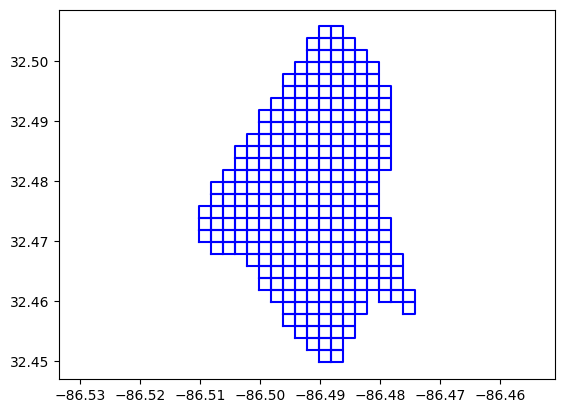

properties found:  0
On sale Scrapped
properties found:  0
Sold Scrapped
Scraping the following tract, total:  100


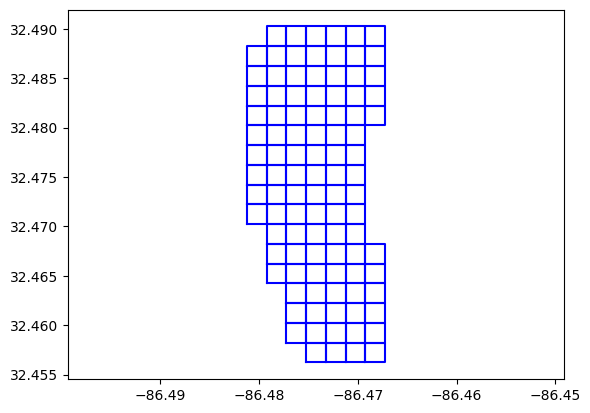

properties found:  0
On sale Scrapped


KeyboardInterrupt: 

In [22]:
# test

tract_data = pd.read_csv('tract_data.csv')
tract_data['geometry'] = tract_data['geometry'].apply(wkt.loads)
gpd.GeoDataFrame(tract_data, geometry='geometry')
main_for_census_tract(tract_data)